In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


# Import & EDA

In [2]:
df=pd.read_excel('wti_oil_price.xlsx')
df=df.set_index('Date')
df.head()

,Price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


In [3]:
print(df.describe())
print('\n')
print(df.info())
print('Missing values: ', df.isna().sum())

             Price
count  9590.000000
mean     46.906030
std      29.647296
min     -36.980000
25%      20.100000
50%      37.870000
75%      69.860000
max     145.310000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9590 entries, 1986-01-02 to 2024-01-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9590 non-null   float64
dtypes: float64(1)
memory usage: 149.8 KB
None
Missing values:  Price    0
dtype: int64


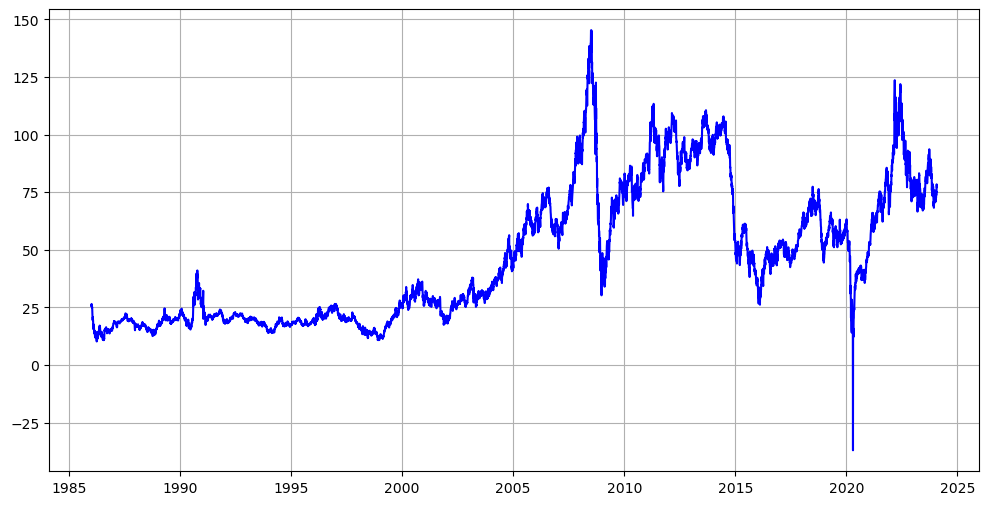

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='b')
plt.grid(True)
plt.show()

In [5]:
start_date = '2004-01-01'
end_date = '2024-02-01'

df = df[(df.index >= start_date) & (df.index <= end_date)]
df.shape

(5040, 1)

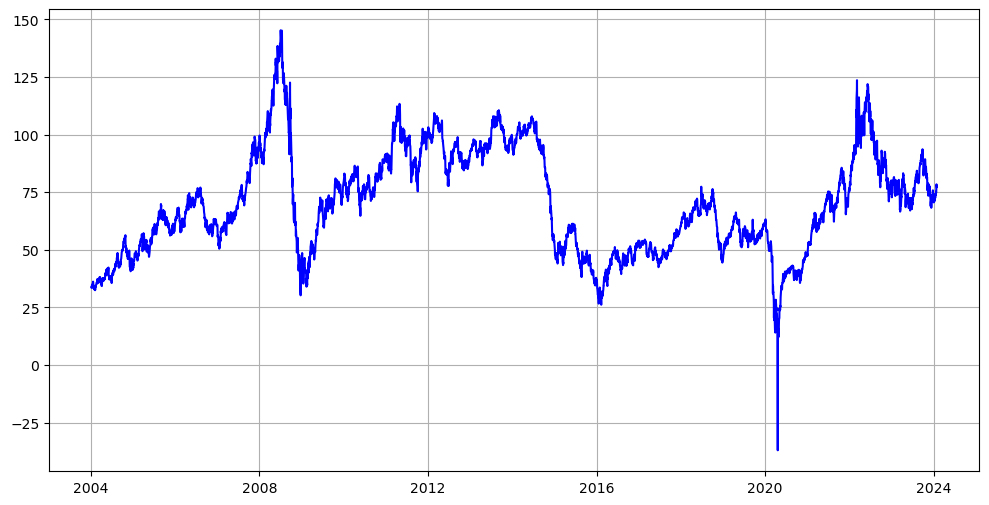

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='b')
plt.grid(True)
plt.show()

In [7]:
# min_val = df['Price'].min()
# second_min_val = df['Price'][df['Price'] != min_val].min()
# df.loc[df['Price'] == min_val, 'Price'] = second_min_val

df=df.reset_index().resample('M', on='Date').mean()
df.shape

(241, 1)

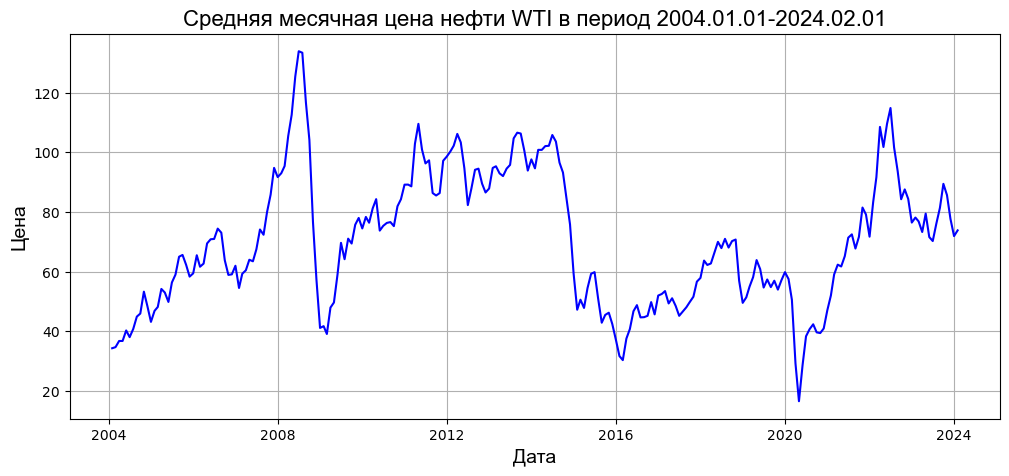

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], color='b')
plt.title('Средняя месячная цена нефти WTI в период 2004.01.01-2024.02.01', fontsize=16, fontname='Arial')
plt.xlabel('Дата', fontsize=14, fontname='Arial')
plt.ylabel('Цена', fontsize=14, fontname='Arial')
plt.grid(True)
plt.show()

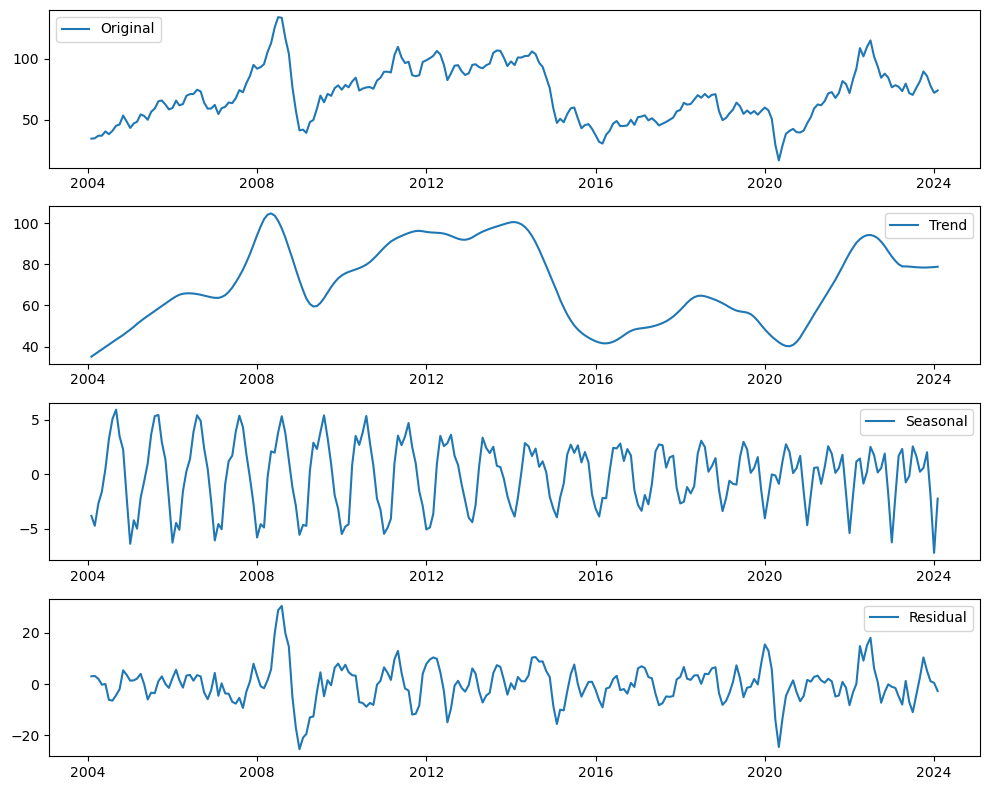

In [9]:
stl_result = STL(df['Price'], seasonal=13).fit()

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(df['Price'], label='Original')
ax1.legend()

ax2.plot(stl_result.trend, label='Trend')
ax2.legend()

ax3.plot(stl_result.seasonal, label='Seasonal')
ax3.legend()

ax4.plot(stl_result.resid, label='Residual')
ax4.legend()

plt.tight_layout()
plt.show()

# SARIMA

In [10]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller


In [286]:
adfuller(df['Price'])[:2]

(-3.4182748407252492, 0.010351437283789702)

In [287]:
adfuller(np.diff(df['Price'], n=12))[:2]

(-17.68993893518916, 3.57604456872285e-30)

In [288]:
from itertools import product

ps, qs, Ps, Qs=range(5), range(5), range(5), range(5)
d, D, s=0, 0, 12

arima_orders=list(product(ps, qs, Ps, Qs))

In [289]:
import pandas as pd
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d:int, D:int, s:int)->pd.DataFrame:
    res=[]
    
    for order in tqdm_notebook(order_list):
        try:
            model=SARIMAX(endog, order=(order[0], d, order[1]), 
                          seasonal_order=(order[2], D, order[3], s),
                          simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic=model.aic
        res.append([order, aic])
        
    res_df=pd.DataFrame(res)
    res_df.columns=['(p,q,P,Q)', 'AIC']
    res_df=res_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return res_df

In [290]:
 train, test=df['Price'][:-3], df['Price'][-3:]
train.shape, test.shape

((238,), (3,))

In [291]:
# arima_res_df=optimize_SARIMA(train, arima_orders, d, D, s) # did on Mac

In [292]:
sarima_model=SARIMAX(train, order=(4,1,3), seasonal_order=(2,0,0,12))
sarima_model_fit=sarima_model.fit(disp=False)

C:\Users\akim2\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


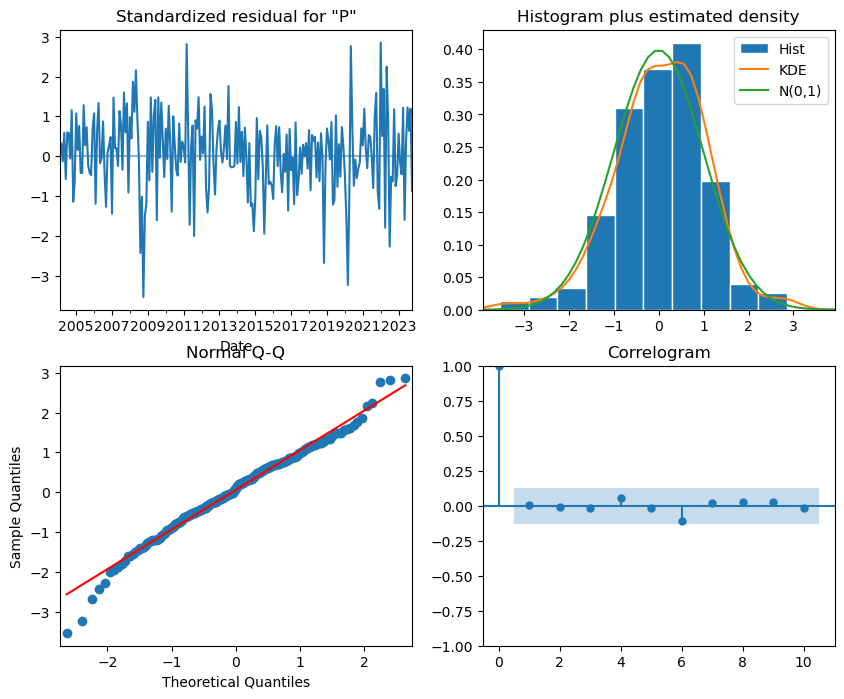

In [293]:
sarima_model_fit.plot_diagnostics(figsize=(10,8));

In [294]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid=sarima_model_fit.resid
acorr_ljungbox(resid, np.arange(1,11))

,lb_stat,lb_pvalue
1,0.004380,0.947235
2,0.004675,0.997665
3,0.090320,0.992973
4,0.929889,0.920234
5,1.114401,0.952821
6,2.725086,0.842475
7,2.924471,0.891900
8,3.001285,0.934277
9,3.599970,0.935718
10,4.009084,0.946936


In [295]:
test

Date
2023-11-30    77.685000
2023-12-31    71.900000
2024-01-31    73.822105
Freq: M, Name: Price, dtype: float64

In [296]:
sarima_preds=sarima_model_fit.get_prediction(train.shape[0], train.shape[0]+test.shape[0]-1).predicted_mean
sarima_preds

2023-11-30    83.744813
2023-12-31    83.455189
2024-01-31    79.822074
Freq: M, Name: predicted_mean, dtype: float64

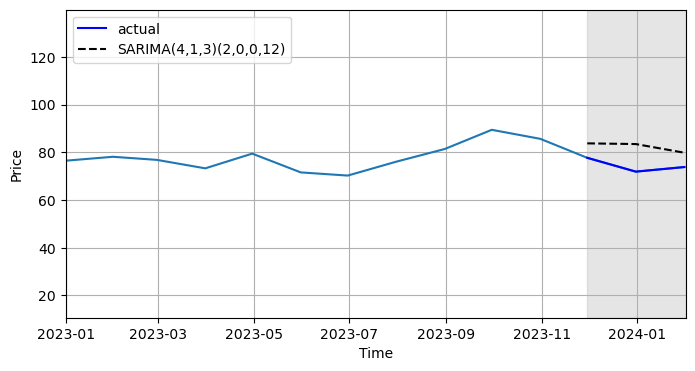

In [297]:
plt.figure(figsize=(8,4))

plt.plot(df['Price'])
plt.plot(test, 'b-', label='actual')
plt.plot(sarima_preds, 'k--', label='SARIMA(4,1,3)(2,0,0,12)')

plt.legend(loc=2)

plt.xlabel('Time')
plt.ylabel('Price')

plt.axvspan('2023-11-30', '2024-02-01', color='#808080', alpha=0.2)

plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-02-01'))

plt.grid();

In [11]:
import numpy as np

def calculate_metrics(actual, predicted):
    """
    Calculate MAE, RMSE, and MAPE.
    
    Parameters:
    actual (array-like): Actual values.
    predicted (array-like): Predicted values.
    
    Returns:
    dict: Dictionary containing MAE, RMSE, and MAPE.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(actual - predicted))
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    metrics = {
        'MAE': mae.round(4),
        'RMSE': rmse.round(4),
        'MAPE': mape.round(4)
    }
    
    return metrics

In [299]:
metrics_result = calculate_metrics(test, sarima_preds)
print(metrics_result)

{'MAE': 7.8717, 'RMSE': 8.2914, 'MAPE': 10.6664}


In [24]:
# {'MAE': 7.8717, 'RMSE': 8.2914, 'MAPE': 10.6664}
# start_date = '2004-01-01'
# end_date = '2024-02-01'
# montly
# SARIMAX(train, order=(4,1,3), seasonal_order=(2,0,0,12))

In [25]:
mean_baseline = np.full_like(test, train.mean())
last_value_baseline = np.full_like(test, train.iloc[-1])

In [26]:
mean_metrics_result = calculate_metrics(test, mean_baseline)
mean_metrics_result

{'MAE': 4.4432, 'RMSE': 5.0527, 'MAPE': 5.8695}

In [27]:
last_value_metrics_result = calculate_metrics(test, last_value_baseline)
last_value_metrics_result

{'MAE': 11.1705, 'RMSE': 11.4266, 'MAPE': 15.1189}

# LSTM

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler

seed_value = 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [49]:
scaler = MinMaxScaler()
input_size, output_size=6, 3 # input_size=6 makes MAPE around 6

def prepare_lstm_dataset(series, input_size=input_size, output_size=output_size, sc=scaler):
    # Normalize the series using MinMaxScaler
    normalized_series = sc.fit_transform(np.array(series).reshape(-1, 1)).flatten()
#     normalized_series=series

    # Initialize empty lists for input and output sequences
    X, y = [], []

    # Generate sliding window input and output sequences
    for i in range(len(normalized_series) - input_size - output_size + 1):
        input_seq = normalized_series[i:i + input_size]
        output_seq = normalized_series[i + input_size:i + input_size + output_size]

        X.append(input_seq)
        y.append(output_seq)

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], input_size, 1))

    return X, y

# Example usage:
# Assuming df is your original dataframe with 'Price' as the column

# Prepare LSTM dataset with sliding window
X_lstm, y_lstm = prepare_lstm_dataset(df['Price'])
X_lstm_train, y_lstm_train=X_lstm[:-1], y_lstm[:-1] 
X_lstm_test, y_lstm_test = prepare_lstm_dataset(df['Price'].values[-(input_size + output_size):], input_size, output_size)

X_lstm_train.shape, y_lstm_train.shape, X_lstm_test.shape, y_lstm_test.shape

((232, 6, 1), (232, 3), (1, 6, 1), (1, 3))

In [94]:
(X_lstm_train.shape[1], X_lstm_train.shape[2])

(6, 1)

In [244]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Assuming X_lstm and y_lstm are your prepared LSTM dataset
input_shape = (X_lstm_train.shape[1], X_lstm_train.shape[2])  # (time steps, features)
output_size = y_lstm_train.shape[1]  # Number of output time steps

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(16, input_shape=input_shape, return_sequences=True))  # Use return_sequences for stacked LSTM layers
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(16, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(16, return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(16, return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(output_size, activation='linear'))  # Dense output layer with linear activation
lstm_model.compile(loss='mean_squared_error', optimizer='adam')  # Compile with mean squared error loss and Adam optimizer

# Early stopping with patience of 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 15s 386ms/step - loss: 0.2290 - val_loss: 0.3294
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 0.1991 - val_loss: 0.2840
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.1653 - val_loss: 0.2253
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 0.1208 - val_loss: 0.1488
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0714 - val_loss: 0.0631
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0439 - val_loss: 0.0194
Epoch 7/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0492 - val_loss: 0.0215
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0387 - val_loss: 0.0357
Epoch 9/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0410 - val_loss: 0.0363
Epoch 10/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0377 - val_loss: 0.0284
Epoch 11/50
7/7 [==========

In [96]:
# X_lstm_test_scaled = scaler.transform(X_lstm_test.reshape(-1, 1)).reshape(X_lstm_test.shape)
y_lstm_pred_scaled = lstm_model.predict(X_lstm_test)
y_lstm_pred_original = scaler.inverse_transform(y_lstm_pred_scaled.reshape(-1, 1)).flatten()
y_lstm_test=scaler.inverse_transform(y_lstm_test.reshape(-1, 1)).flatten()

metrics_lstm = calculate_metrics(y_lstm_test.flatten(), y_lstm_pred_original)
print("LSTM Metrics:", metrics_lstm)

1/1 [==============================] - 2s 2s/step
LSTM Metrics: {'MAE': 3.5365, 'RMSE': 4.2505, 'MAPE': 4.8549}


In [97]:
print(y_lstm_pred_original)
y_lstm_test

[78.03878  77.890045 78.08763 ]


array([77.685     , 71.9       , 73.82210526])

In [43]:
# LSTM Metrics: {'MAE': 6.6644, 'RMSE': 7.2302, 'MAPE': 9.0687}
# scaler = MinMaxScaler()
# input_size, output_size=3, 3
# start_date = '2004-01-01'
# end_date = '2024-02-01'
# montly


# lstm_model = Sequential()
# lstm_model.add(LSTM(16, input_shape=input_shape, return_sequences=True))  
# lstm_model.add(Dropout(0.2))

# lstm_model.add(LSTM(16, return_sequences=True))
# lstm_model.add(Dropout(0.2))

# lstm_model.add(LSTM(16, return_sequences=True))
# lstm_model.add(Dropout(0.2))

# lstm_model.add(LSTM(16, return_sequences=False))
# lstm_model.add(Dropout(0.2))

# lstm_model.add(Dense(output_size, activation='linear'))  
# lstm_model.compile(loss='mean_squared_error', optimizer='adam')  

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# lstm_model.fit(X_lstm_train, y_lstm_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Chap 3. Multivalriate LSTM+Outlier removal

## Gold df

In [13]:
# gold_df=pd.read_csv('Gold Futures Historical Data.csv')[['Date', 'Price']]
# gold_df['Date'] = pd.to_datetime(gold_df['Date'], format='%m/%d/%Y')
# gold_df.sort_values(by='Date', inplace=True)
# gold_df.reset_index(drop=True, inplace=True)
# gold_df=gold_df.set_index('Date')

# gold_df['Price']=pd.to_numeric(gold_df['Price'].str.replace(',', ''), errors='coerce')

# gold_df_small=pd.read_csv('Gold Futures Historical Data_small.csv')[['Date', 'Price']]
# gold_df_small['Date'] = pd.to_datetime(gold_df_small['Date'], format='%m/%d/%Y')
# gold_df_small.sort_values(by='Date', inplace=True)
# gold_df_small.reset_index(drop=True, inplace=True)
# gold_df_small=gold_df_small.set_index('Date')
# gold_df_small['Price']=pd.to_numeric(gold_df_small['Price'].str.replace(',', ''), errors='coerce')

# gold_df = pd.concat([gold_df, gold_df_small])
# gold_df=gold_df[~gold_df.index.duplicated(keep='first')]
# gold_df = gold_df[(gold_df.index >= start_date) & (gold_df.index <= end_date)]
# gold_df=gold_df.reset_index().resample('M', on='Date').mean()
# gold_df

In [14]:
import yfinance as yf

# Define the ticker symbol for gold
ticker_symbol = "GC=F"

# Download the data
gold_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the first few rows of the data
gold_data=gold_data['Close'].reset_index().resample('M', on='Date').mean()
gold_data.columns=['Close_Gold']
gold_data

[*********************100%%**********************]  1 of 1 completed


,Close_Gold
Date,
2004-01-31,414.726317
2004-02-29,403.952630
2004-03-31,407.469565
2004-04-30,403.957142
2004-05-31,383.769995
...,...
2023-09-30,1912.409998
2023-10-31,1915.568176
2023-11-30,1985.649997


## US Dollar index df

In [15]:
from scipy.stats import zscore as zs
from scipy import linalg as scipy_linalg

# us_df=pd.read_csv('US Dollar Index Futures Historical Data.csv')[['Date', 'Price']]
# us_df['Date'] = pd.to_datetime(us_df['Date'], format='%b %d, %Y')
# us_df.sort_values(by='Date', inplace=True)
# us_df.reset_index(drop=True, inplace=True)
# us_df=us_df.set_index('Date')

# us_df_small=pd.read_csv('US Dollar Index Futures Historical Data_small.csv')[['Date', 'Price']]
# us_df_small['Date'] = pd.to_datetime(us_df_small['Date'], format='%b %d, %Y')
# us_df_small.sort_values(by='Date', inplace=True)
# us_df_small.reset_index(drop=True, inplace=True)
# us_df_small=us_df_small.set_index('Date')

# us_df = pd.concat([us_df, us_df_small])
# us_df=us_df[~us_df.index.duplicated(keep='first')]
# us_df = us_df[(us_df.index >= start_date) & (us_df.index <= end_date)]
# us_df=us_df.reset_index().resample('M', on='Date').mean()
# us_df

In [16]:
import yfinance as yf

# Define the ticker symbol for US Dollar Index
ticker_symbol = "DX-Y.NYB"

# Download the data
usdx_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the first few rows of the data
usdx_data=usdx_data['Close'].reset_index().resample('M', on='Date').mean()
usdx_data.columns=['Close_USDX']
usdx_data

[*********************100%%**********************]  1 of 1 completed


,Close_USDX
Date,
2004-01-31,86.441428
2004-02-29,86.347499
2004-03-31,88.457826
2004-04-30,89.836191
2004-05-31,90.548999
...,...
2023-09-30,105.331499
2023-10-31,106.353182
2023-11-30,104.527143


## S&P500

In [17]:
import yfinance as yf

ticker_symbol = "^GSPC"

sp500_data = yf.download(ticker_symbol, start=start_date, end=end_date)

sp500_data=sp500_data['Close'].reset_index().resample('M', on='Date').mean()
sp500_data.columns=['Close_S&P']
sp500_data

[*********************100%%**********************]  1 of 1 completed


,Close_S&P
Date,
2004-01-31,1132.517499
2004-02-29,1143.356323
2004-03-31,1123.978245
2004-04-30,1133.078573
2004-05-31,1102.781500
...,...
2023-09-30,4409.094995
2023-10-31,4269.400945
2023-11-30,4460.063314


## Dow Jones

In [18]:
start_date, end_date

('2004-01-01', '2024-02-01')

In [19]:
import yfinance as yf

# Define the ticker symbol for Dow Jones Industrial Average
ticker_symbol = "^DJI"

# Download the data
dow_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the first few rows of the data
dow_data=dow_data['Close'].reset_index().resample('M', on='Date').mean()
dow_data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2004-01-31,10540.046973
2004-02-29,10601.498972
2004-03-31,10323.728261
2004-04-30,10418.404250
2004-05-31,10083.805469
...,...
2023-09-30,34318.890820
2023-10-31,33319.492720
2023-11-30,34704.502418


## Dow Jones U.S. Oil & Gas Index

In [20]:
# https://www.investing.com/indices/dj-oil---gas-historical-data
dowog_df=pd.read_csv('Dow Jones Oil & Gas Historical Data.csv', delimiter='\t')
dowog_df['Date'] = pd.to_datetime(dowog_df['Date'])
dowog_df.sort_values(by='Date', inplace=True)
dowog_df['Date']= dowog_df['Date'] + pd.offsets.DateOffset(months=1) - pd.offsets.Day(1)  # Shift to end of the month
dowog_df=dowog_df.set_index('Date')[['Price']]
dowog_df.head()

C:\Users\akim2\AppData\Local\Temp\ipykernel_2916\2701782694.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dowog_df['Date'] = pd.to_datetime(dowog_df['Date'])


,Price
Date,
2004-01-31,249.49
2004-02-29,260.01
2004-03-31,258.45
2004-04-30,263.18
2004-05-31,262.26


## Non-US Oil and Gas Companies

In [21]:
# https://finance.yahoo.com/u/yahoo-finance/watchlists/oil-and-gas-stocks/
# https://companiesmarketcap.com/oil-gas/largest-oil-and-gas-companies-by-market-cap/
# from here filter out all US companies

top_30_df=pd.read_csv('top_30_comps.csv')
top_30_df=top_30_df.sort_values(by='marketcap', ascending=False)[:30]
top_30_df['marketcap']=top_30_df['marketcap']/1e9
top_30_df=top_30_df[top_30_df['country']!='United States'].reset_index(drop=True)

country_currency = {
    'Saudi Arabia': 'SAR',
    'China': 'CNY',
    'United Kingdom': 'GBP',
    'France': 'EUR',
    'United Arab Emirates': 'AED',
    'Brazil': 'BRL',
    'Canada': 'CAD',
    'Norway': 'NOK',
    'Russia': 'RUB',
    'Italy': 'EUR'
}

top_30_df['currency'] = top_30_df['country'].map(country_currency)

top_30_df

,Rank,Name,Symbol,marketcap,price (USD),country,currency
0,1,Saudi Aramco,2222.SR,1991.402287,8.23,Saudi Arabia,SAR
1,4,PetroChina,601857.SS,226.027384,1.29,China,CNY
2,5,Shell,SHEL,215.975592,66.92,United Kingdom,GBP
3,6,TotalEnergies,TTE,159.923978,67.84,France,EUR
4,8,CNOOC,0883.HK,121.118843,2.30,China,CNY
5,9,BP,BP,107.455193,37.80,United Kingdom,GBP
6,10,TAQA,TAQA.AE,100.743146,0.90,United Arab Emirates,AED
7,11,Sinopec,600028.SS,98.033295,0.86,China,CNY
8,12,Petrobras,PBR,94.933828,14.69,Brazil,BRL
9,13,Canadian Natural Resources,CNQ,79.770124,74.10,Canada,CAD


In [22]:
import numpy as np

def calculate_weights(df):
    df['Weight'] = np.sqrt(df['marketcap'])
    df['Weight'] = df['Weight'] / df['Weight'].sum()
    return df

In [23]:
top_30_df=calculate_weights(top_30_df)
top_30_df[['Name', 'Symbol', 'Weight']]

,Name,Symbol,Weight
0,Saudi Aramco,2222.SR,0.228638
1,PetroChina,601857.SS,0.077028
2,Shell,SHEL,0.075296
3,TotalEnergies,TTE,0.064793
4,CNOOC,0883.HK,0.056387
5,BP,BP,0.053111
6,TAQA,TAQA.AE,0.051425
7,Sinopec,600028.SS,0.050729
8,Petrobras,PBR,0.049921
9,Canadian Natural Resources,CNQ,0.045760


In [24]:
import yfinance as yf
import pandas as pd

def fetch_stock_prices(symbols, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date)
    stock_prices = pd.DataFrame(index=date_range)
    
    for symbol in symbols:
        data = yf.download(symbol, start=start_date, end=end_date)
        data.index = pd.to_datetime(data.index)  # Ensure index is datetime
        data = data['Close'].reindex(date_range)  # Reindex to fill missing dates
        stock_prices[symbol] = data
        
    return stock_prices

# Fetch stock prices for each company
stock_prices = fetch_stock_prices(top_30_df['Symbol'].to_list(), start_date, end_date)

stock_prices.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TAQA.AE']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Fa

,2222.SR,601857.SS,SHEL,TTE,0883.HK,BP,TAQA.AE,600028.SS,PBR,CNQ,EQNR,ENB,ADNOCGAS.AE,ROSN.ME,LKOH.ME,E
2004-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.807692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-02,NaN,NaN,52.750000,46.625,NaN,49.400002,NaN,4.007692,7.55,6.362635,11.41,10.4825,NaN,NaN,NaN,38.751999
2004-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-05,NaN,NaN,53.529999,47.730,NaN,49.900002,NaN,4.376923,8.10,6.754407,11.52,10.4475,NaN,NaN,NaN,39.408001


In [25]:
# ADNOC first date 03/14/2023, ignore
# Taga got from https://www.investing.com/equities/ad-natl-energy-historical-data

taga=pd.read_csv('TAQA Historical Data.csv')
# taga['Price']=taga['Price']*0.27
taga['Date'] = pd.to_datetime(taga['Date'], format='%m/%d/%Y')
taga.sort_values(by='Date', inplace=True)
taga.reset_index(drop=True, inplace=True)
taga=taga.set_index('Date')
taga=taga[(taga.index >= start_date) & (taga.index < end_date)]
date_range = pd.date_range(start=start_date, end=end_date)
taga_price = taga['Price'].reindex(date_range)

top_30_df=top_30_df[~top_30_df['Name'].isin(['ADNOC Gas'])]

stock_prices['TAQA.AE']=taga_price
stock_prices=stock_prices.drop('ADNOCGAS.AE', axis=1)
stock_prices.head()

,2222.SR,601857.SS,SHEL,TTE,0883.HK,BP,TAQA.AE,600028.SS,PBR,CNQ,EQNR,ENB,ROSN.ME,LKOH.ME,E
2004-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.807692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-02,NaN,NaN,52.750000,46.625,NaN,49.400002,NaN,4.007692,7.55,6.362635,11.41,10.4825,NaN,NaN,38.751999
2004-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-05,NaN,NaN,53.529999,47.730,NaN,49.900002,NaN,4.376923,8.10,6.754407,11.52,10.4475,NaN,NaN,39.408001


In [26]:
(stock_prices.isna().sum()/stock_prices.shape[0]).sort_values(ascending=False)

2222.SR      0.858798
ROSN.ME      0.585253
LKOH.ME      0.585253
601857.SS    0.461360
TAQA.AE      0.377130
0883.HK      0.329971
600028.SS    0.329562
SHEL         0.311163
TTE          0.311163
BP           0.311163
PBR          0.311163
CNQ          0.311163
EQNR         0.311163
ENB          0.311163
E            0.311163
dtype: float64

In [27]:
def fetch_currency_exchange_rates(currencies, start_date, end_date):
    exchange_rates = {}
    for currency in currencies:
        data = yf.download(f"{currency}=X", start=start_date, end=end_date)
        exchange_rates[currency] = data['Close']
        
    exchange_rates_df = pd.DataFrame(exchange_rates)
    return exchange_rates_df

currencies = top_30_df['currency'].unique()
exchange_rates_df = fetch_currency_exchange_rates(currencies, start_date, end_date)

stock_prices = pd.merge(stock_prices, exchange_rates_df, left_index=True, right_index=True)

currency_dict = dict(zip(top_30_df['Symbol'], top_30_df['currency']))

for symbol, currency in currency_dict.items():
    stock_prices[symbol] /= stock_prices[currency]

stock_prices.drop(columns=currencies, inplace=True)
stock_prices.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,2222.SR,601857.SS,SHEL,TTE,0883.HK,BP,TAQA.AE,600028.SS,PBR,CNQ,EQNR,ENB,ROSN.ME,LKOH.ME,E
2024-01-25,8.423277,1.128212,79.479552,70.633431,2.038972,44.706454,0.871460,0.831686,3.379625,47.636299,2.756745,26.387388,NaN,NaN,34.767186
2024-01-26,NaN,1.200378,80.278057,71.091540,2.059002,45.279521,0.865876,0.821906,3.468408,47.730698,2.796852,26.644012,NaN,NaN,35.079347
2024-01-29,8.342532,1.185336,80.515525,71.079260,2.074338,45.241575,0.863207,0.836791,3.492348,47.458005,2.786646,26.720679,NaN,NaN,35.035406
2024-01-30,8.356788,1.185687,81.225047,71.518344,2.046722,45.627906,0.857843,0.837039,3.442285,48.481139,2.828181,26.827922,NaN,NaN,35.157859
2024-01-31,8.170103,1.178444,79.867462,70.677280,2.038314,44.561243,0.857843,0.840135,3.448276,47.747674,2.746887,26.489176,NaN,NaN,34.644663


In [28]:
def calculate_weighted_average(stock_prices, top_30_df):
    weighted_avg_prices = pd.DataFrame(index=stock_prices.index)
    
    for idx, row in top_30_df.iterrows():
        symbol = row['Symbol']
        weight = row['Weight']
        
        weighted_avg_prices[symbol] = stock_prices[symbol] * weight
        
    weighted_avg_prices['Index'] = weighted_avg_prices.mean(axis=1)
    
    return weighted_avg_prices

weighted_avg_prices = calculate_weighted_average(stock_prices, top_30_df)
weighted_avg_prices.index.name = 'Date'
weighted_avg_prices.index = pd.to_datetime(weighted_avg_prices.index)
weighted_avg_prices.head()

non_us_ind=weighted_avg_prices['Index'].reset_index().resample('M', on='Date').mean()
non_us_ind.head()

,Index
Date,
2004-01-31,1.887324
2004-02-29,1.881288
2004-03-31,1.873165
2004-04-30,1.822214
2004-05-31,1.800085


## Final df

In [70]:
# merged_df = pd.merge(gold_df, us_df, left_index=True, right_index=True)
merged_df = pd.merge(gold_data, usdx_data, on='Date').merge(sp500_data, on='Date').merge(dowog_df, on='Date')\
    .merge(non_us_ind, on='Date')

final_df=pd.merge(df, merged_df, left_index=True, right_index=True)
final_df.columns=['WTI', 'GOLD', 'USD', 'S&P', 'DOWJONES_OG', 'NON_US_IND']
final_df.head()

,WTI,GOLD,USD,S&P,DOWJONES_OG,NON_US_IND
Date,,,,,,
2004-01-31,34.310000,414.726317,86.441428,1132.517499,249.49,1.887324
2004-02-29,34.684737,403.952630,86.347499,1143.356323,260.01,1.881288
2004-03-31,36.741304,407.469565,88.457826,1123.978245,258.45,1.873165
2004-04-30,36.750000,403.957142,89.836191,1133.078573,263.18,1.822214
2004-05-31,40.275000,383.769995,90.548999,1102.781500,262.26,1.800085


## Outliers

In [71]:
zscore = np.abs(zs(final_df['WTI']))
zscore_df = final_df.copy()
zscore_df['zscore'] = zscore

In [72]:
len(zscore_df[zscore_df['zscore']>=2.0])

6

## Correlation test

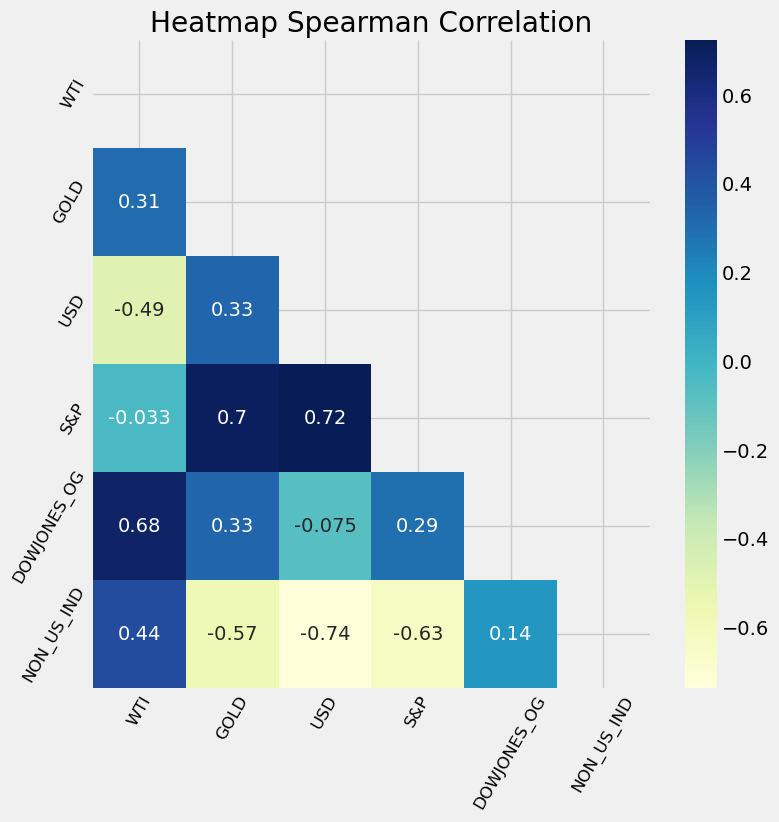

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
matrix = np.triu(final_df.corr(method='spearman'))
heat_map = sns.heatmap(final_df.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=60)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=60)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

## Final modelling

In [74]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2.0, :]
zscore_df.shape

(235, 7)

In [75]:
scaler_2 = MinMaxScaler()
input_size, output_size=6, 3

def prepare_lstm_dataframe(series, input_size=input_size, output_size=output_size, sc=scaler_2):
    """
    Prepare dataset for LSTM modeling with a sliding window.

    Parameters:
    series (pd.DataFrame): Time series data with multiple columns.
    input_size (int): Number of input time steps.
    output_size (int): Number of output time steps.

    Returns:
    tuple: Tuple containing input and output sequences.
    """
    normalized_series = sc.fit_transform(series.values)
#     normalized_series=series.values

    # Initialize empty lists for input and output sequences
    X, y = [], []

    # Generate sliding window input and output sequences
    for i in range(len(normalized_series) - input_size - output_size + 1):
        input_seq = normalized_series[i:i + input_size, :]  # Include all columns
        output_seq = normalized_series[i + input_size:i + input_size + output_size, 0]  # Only the first column

        X.append(input_seq)
        y.append(output_seq)

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], input_size, series.shape[1]))  # Keep all columns in features

    return X, y

In [76]:
selected_cols= ['WTI'
                ,'GOLD'
                ,'USD'
#                 , 'S&P'
                , 'DOWJONES_OG'
#                 ,'NON_US_IND'
               ]

X_final, y_final=prepare_lstm_dataframe(zscore_df[selected_cols])
X_final_train, y_final_train=X_final[:-1], y_final[:-1] 
X_final_test, y_final_test = prepare_lstm_dataframe(zscore_df[selected_cols].iloc[-(input_size + output_size):], input_size, output_size)

In [77]:
X_final[0], y_final[0]

(array([[0.068408  , 0.01878526, 0.35969241, 0.01637371],
        [0.0728682 , 0.01224745, 0.35733383, 0.03372028],
        [0.09734591, 0.01438164, 0.41032435, 0.03114797],
        [0.09744941, 0.01225019, 0.44493524, 0.03894733],
        [0.13940473, 0.        , 0.46283394, 0.03743033],
        [0.11262757, 0.00510692, 0.42783048, 0.06300498]]),
 array([0.14539268, 0.19449036, 0.20677978]))

In [234]:
(X_final_train.shape[1], X_final_train.shape[2])

(6, 3)

In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Assuming X_final_train and y_final_train are your new prepared LSTM dataset
input_shape = (X_final_train.shape[1], X_final_train.shape[2])  # (time steps, features)
output_size = y_final_train.shape[1]  # Number of output time steps

# Build the LSTM model
lstm_model_new = Sequential()
lstm_model_new.add(LSTM(64, input_shape=input_shape, return_sequences=True))  
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(LSTM(64, return_sequences=True))
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(LSTM(32, return_sequences=True))
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(LSTM(32, return_sequences=False))
lstm_model_new.add(Dropout(0.2))

lstm_model_new.add(Dense(output_size, activation='linear'))  
lstm_model_new.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=5e-4))  

# Early stopping with patience of 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
lstm_model_new.fit(X_final_train, y_final_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/50
7/7 [==============================] - 10s 328ms/step - loss: 0.2685 - val_loss: 0.3950
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 0.2227 - val_loss: 0.2985
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 0.1598 - val_loss: 0.1610
Epoch 4/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0913 - val_loss: 0.0360
Epoch 5/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0662 - val_loss: 0.0317
Epoch 6/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0640 - val_loss: 0.0340
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0539 - val_loss: 0.0485
Epoch 8/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0518 - val_loss: 0.0339
Epoch 9/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0432 - val_loss: 0.0280
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0437 - val_loss: 0.0324
Epoch 11/50
7/7 [==========

In [99]:
1e-3, 5e-2
# val_loss: 0.0574

(0.001, 0.05)

In [100]:
y_final_test

array([77.685     , 71.9       , 73.82210526])

In [101]:
y_final_pred_scaled = lstm_model_new.predict(X_final_test)
y_final_pred_original = scaler.inverse_transform(y_final_pred_scaled.reshape(-1, 1)).flatten()
if y_final_test.flatten()[0]<1:
    y_final_test=scaler.inverse_transform(y_final_test.reshape(-1, 1)).flatten()

metrics_lstm = calculate_metrics(y_final_test.flatten(), y_final_pred_original)
print("LSTM Metrics:", metrics_lstm)

1/1 [==============================] - 2s 2s/step
LSTM Metrics: {'MAE': 3.4221, 'RMSE': 4.1917, 'MAPE': 4.7038}


In [ ]:
print(y_lstm_pred_original)
print(y_final_pred_original)
y_final_test

In [63]:
# [80.35133 80.17848 81.8968 ]
# [78.833626 78.395836 79.11392 ]
# array([78.69628739, 73.40960915, 75.16614365])

In [169]:
from tensorflow.keras.models import save_model, load_model


# save_model(lstm_model, "lstm_model_univariate_oil.h5")
# save_model(lstm_model_new, "lstm_model_multivariate_oil.h5")

C:\Users\akim2\AppData\Local\Temp\ipykernel_12760\975136017.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(lstm_model, "lstm_model_univariate_oil.h5")
C:\Users\akim2\AppData\Local\Temp\ipykernel_12760\975136017.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(lstm_model_new, "lstm_model_multivariate_oil.h5")


In [170]:
import joblib

# joblib.dump(scaler, 'minmax_scaler_univariate_oil.joblib')
# joblib.dump(scaler_2, 'minmax_scaler_multivariate_oil.joblib')

['minmax_scaler_multivariate_oil.joblib']

In [570]:
# LSTM Metrics: {'MAE': 3.2131, 'RMSE': 3.806, 'MAPE': 4.3222}
# input_size, output_size=6, 3

# lstm_model_new = Sequential()
# lstm_model_new.add(LSTM(64, input_shape=input_shape, return_sequences=True))  # Use return_sequences for stacked LSTM layers
# lstm_model_new.add(Dropout(0.2))

# lstm_model_new.add(LSTM(64, return_sequences=True))
# lstm_model_new.add(Dropout(0.2))

# lstm_model_new.add(LSTM(32, return_sequences=True))
# lstm_model_new.add(Dropout(0.2))

# lstm_model_new.add(LSTM(32, return_sequences=False))
# lstm_model_new.add(Dropout(0.2))

# lstm_model_new.add(Dense(output_size, activation='linear'))  
# lstm_model_new.compile(loss='mean_squared_error', optimizer='adam')  

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# lstm_model_new.fit(X_final_train, y_final_train, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])


# Experimenting with many runs

## Multivariate LSTM

In [217]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


input_size, output_size=6, 3


selected_cols= ['WTI'
                ,'GOLD'
                ,'USD'
#                 , 'S&P'
#                 , 'DOWJONES_OG'
#                 ,'NON_US_IND'
               ]

zscore_reduced=zscore_df[selected_cols]

X_final, y_final=prepare_lstm_dataframe(zscore_reduced)
X_final_train, y_final_train=X_final[:-1], y_final[:-1] 
X_final_test, y_final_test = prepare_lstm_dataframe(zscore_reduced.iloc[-(input_size + output_size):], input_size, output_size)

In [218]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm_notebook
import keras.backend as K


# Assuming X_final_train and y_final_train are your new prepared LSTM dataset
input_shape = (X_final_train.shape[1], X_final_train.shape[2])  # (time steps, features)
output_size = y_final_train.shape[1]  # Number of output time steps


def build_lstm_multivar_model(input_shape=input_shape, output_size=output_size):
    lstm_model_new = Sequential()
    lstm_model_new.add(LSTM(64, input_shape=input_shape, return_sequences=True))  
    lstm_model_new.add(Dropout(0.2))

    lstm_model_new.add(LSTM(64, return_sequences=True))
    lstm_model_new.add(Dropout(0.2))
    
    lstm_model_new.add(LSTM(32, return_sequences=True))
    lstm_model_new.add(Dropout(0.2))

    lstm_model_new.add(LSTM(32, return_sequences=False))
    lstm_model_new.add(Dropout(0.2))
    
    lstm_model_new.add(Dense(output_size, activation='linear')) 
    return lstm_model_new


def train_and_evaluate(model_builder, X_train, y_train, X_test, y_test, num_runs=5, scaler=scaler, lr=5e-4):
    results = {'MAE': [],
              'RMSE': [],
              'MAPE': []}

    for i in tqdm_notebook(range(num_runs)):
        model = model_builder()
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.1, callbacks=[early_stopping])
        y_pred = model.predict(X_test)
        
        if y_test.flatten()[0]<1:
            y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        mae, rmse, mape=list(calculate_metrics(y_test.flatten(), y_pred).values())
        results['MAE'].append(mae)
        results['RMSE'].append(rmse)
        results['MAPE'].append(mape)
        
        print(mae, rmse, mape)
        
        K.clear_session()


    results_df = pd.DataFrame(results)
    avg_metrics = results_df.mean(axis=0)
    avg_metrics.name = 'Average'
    results_df = pd.concat([results_df, avg_metrics.to_frame().T])
    results_df.index = list(range(1, num_runs + 1)) + ['Average']

    return results_df


In [219]:
multivar_lstm_ress=train_and_evaluate(build_lstm_multivar_model, 
                   X_final_train, 
                   y_final_train,
                   X_final_test,
                   y_final_test,
                  35)

multivar_lstm_ress

C:\Users\akim2\AppData\Local\Temp\ipykernel_2916\3816072076.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(num_runs)):


  0%|          | 0/35 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
3.519 4.1986 4.8283
1/1 [==============================] - 2s 2s/step
3.1364 3.8439 4.3114
1/1 [==============================] - 2s 2s/step
3.1062 3.7758 4.2676
1/1 [==============================] - 2s 2s/step
4.1802 4.5836 5.6966
1/1 [==============================] - 2s 2s/step
3.2846 4.006 4.5135
1/1 [==============================] - 2s 2s/step
4.2335 4.9814 5.8035
1/1 [==============================] - 2s 2s/step
3.4258 4.2323 4.7116
1/1 [==============================] - 2s 2s/step
3.3065 4.0402 4.5443
1/1 [==============================] - 2s 2s/step
3.5502 4.3177 4.8778
1/1 [==============================] - 2s 2s/step
4.1842 4.6558 5.7119
1/1 [==============================] - 2s 2s/step
3.3934 4.0756 4.6584
1/1 [==============================] - 2s 2s/step
3.5065 4.0935 4.804
1/1 [==============================] - 2s 2s/step
3.3425 4.0932 4.5945
1/1 [==============================] - 2s 2s/step
3.3814 4.1912 4.6516
1/1 [====

,MAE,RMSE,MAPE
1,3.519000,4.198600,4.828300
2,3.136400,3.843900,4.311400
3,3.106200,3.775800,4.267600
4,4.180200,4.583600,5.696600
5,3.284600,4.006000,4.513500
6,4.233500,4.981400,5.803500
7,3.425800,4.232300,4.711600
8,3.306500,4.040200,4.544300
9,3.550200,4.317700,4.877800
10,4.184200,4.655800,5.711900


## Univariate LSTM

In [227]:
input_size, output_size=6, 3

X_lstm, y_lstm = prepare_lstm_dataset(df['Price'])
X_lstm_train, y_lstm_train=X_lstm[:-1], y_lstm[:-1] 
X_lstm_test, y_lstm_test = prepare_lstm_dataset(df['Price'].values[-(input_size + output_size):], input_size, output_size)

In [225]:
input_shape = (X_lstm_train.shape[1], X_lstm_train.shape[2])  # (time steps, features)
output_size = y_lstm_train.shape[1]  # Number of output time steps


def build_lstm_univar_model(input_shape=input_shape, output_size=output_size):
    lstm_model = Sequential()
    lstm_model.add(LSTM(16, input_shape=input_shape, return_sequences=True)) 
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(16, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(16, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(16, return_sequences=False))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(output_size, activation='linear'))  
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')  
    return lstm_model

In [226]:
univar_lstm_ress=train_and_evaluate(build_lstm_univar_model, 
                   X_lstm_train, 
                   y_lstm_train,
                   X_lstm_test,
                   y_lstm_test,
                  35)

univar_lstm_ress

C:\Users\akim2\AppData\Local\Temp\ipykernel_2916\3816072076.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(num_runs)):


  0%|          | 0/35 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
4.3974 4.8973 6.0005
1/1 [==============================] - 2s 2s/step
4.0529 4.5082 5.5322
1/1 [==============================] - 2s 2s/step
2.7736 3.235 3.798
1/1 [==============================] - 2s 2s/step
3.273 4.0044 4.4986
1/1 [==============================] - 2s 2s/step
4.1892 4.6632 5.7159
1/1 [==============================] - 2s 2s/step
4.5007 5.042 6.1457
1/1 [==============================] - 2s 2s/step
4.0412 4.5004 5.5171
1/1 [==============================] - 2s 2s/step
3.3952 3.8592 4.6426
1/1 [==============================] - 3s 3s/step
3.9871 4.8493 5.4777
1/1 [==============================] - 2s 2s/step
2.916 3.31 3.9869
1/1 [==============================] - 2s 2s/step
3.0619 3.7193 4.2064
1/1 [==============================] - 2s 2s/step
3.8534 4.6547 5.2898
1/1 [==============================] - 2s 2s/step
3.933 4.7475 5.4008
1/1 [==============================] - 3s 3s/step
4.3363 4.9769 5.9317
1/1 [=========

,MAE,RMSE,MAPE
1,4.397400,4.897300,6.000500
2,4.052900,4.508200,5.532200
3,2.773600,3.235000,3.798000
4,3.273000,4.004400,4.498600
5,4.189200,4.663200,5.715900
6,4.500700,5.042000,6.145700
7,4.041200,4.500400,5.517100
8,3.395200,3.859200,4.642600
9,3.987100,4.849300,5.477700
10,2.916000,3.310000,3.986900


In [90]:
# with pd.ExcelWriter('model_exp.xlsx', mode='a') as writer:
#     univar_lstm_ress.to_excel(writer, sheet_name='univar_oil')
#     multivar_lstm_ress.to_excel(writer, sheet_name='multivar_oil')

## Stat tests

In [220]:
# cannot use, metrics are not gaussian

from scipy import stats

for m in ['MAE', 'RMSE', "MAPE"]:
    metrics_model_uni = univar_lstm_ress[m].iloc[:-1].to_list()
    metrics_model_multi = multivar_lstm_ress[m].iloc[:-1].to_list()

    # Perform independent samples t-test
    t_statistic, p_value = stats.ttest_ind(metrics_model_uni, metrics_model_multi)

    # Print the results
    print(m)
    print(f'\tUnivariate: mean={np.mean(metrics_model_uni).round(4)}, std={np.std(metrics_model_uni).round(4)}')
    print(f'\tMultivariate: mean={np.mean(metrics_model_multi).round(4)}, std={np.std(metrics_model_multi).round(4)}')
    print("\tt-statistic:", round(t_statistic, 4))
    print("\tp-value:", round(p_value, 4), end='\n\n')


MAE
	Univariate: mean=3.6007, std=0.469
	Multivariate: mean=3.5086, std=0.3296
	t-statistic: 0.9375
	p-value: 0.3518

RMSE
	Univariate: mean=4.2664, std=0.5846
	Multivariate: mean=4.2176, std=0.2843
	t-statistic: 0.4375
	p-value: 0.6631

MAPE
	Univariate: mean=4.9363, std=0.6432
	Multivariate: mean=4.816, std=0.4418
	t-statistic: 0.899
	p-value: 0.3718



In [235]:
from scipy import stats

# Data for model 1
mae_model1 = [2.929, 4.0194, 3.2388, 3.7699, 2.82, 3.5679, 3.2473, 4.5354, 3.9291, 2.9947,
              3.9418, 3.6989, 3.1463, 2.9751, 4.1826, 4.2296, 3.6655, 3.8279, 3.1532, 3.7605,
              3.7045, 3.4793, 4.2747, 4.083, 3.1041, 3.7324, 3.042, 4.048, 4.0711, 3.951,
              3.1228, 3.8589, 3.2054, 2.7722, 3.9432]

rmse_model1 = [3.3255, 4.8308, 3.8164, 4.6864, 3.2217, 4.6195, 3.9546, 5.124, 4.7058, 3.4425,
               4.5461, 4.3843, 3.9104, 3.3741, 4.8313, 5.047, 4.6034, 4.7044, 3.8613, 4.5344,
               4.0886, 4.1127, 4.8049, 4.8793, 3.5708, 4.406, 3.4016, 4.8077, 4.6807, 4.7496,
               3.8023, 4.6073, 3.9895, 3.0294, 4.8705]

mape_model1 = [4.0043, 5.5146, 4.4403, 5.186, 3.8576, 4.9197, 4.4617, 6.1988, 5.3907, 4.0981,
               5.3959, 5.0713, 4.329, 4.0665, 5.7261, 5.8025, 5.0408, 5.2627, 4.3342, 5.159,
               5.0538, 4.771, 5.8341, 5.5981, 4.2481, 5.1163, 4.1525, 5.5455, 5.5691, 5.4242,
               4.2908, 5.2952, 4.4107, 3.777, 5.4229]

# Data for model 2
mae_model2 = [3.1455, 3.4127, 3.3134, 3.0745, 3.1194, 3.0543, 3.2066, 3.1939, 3.222, 3.1639,
              3.79, 3.8149, 3.4929, 3.5883, 4.3129, 3.075, 2.9777, 2.9992, 3.206, 3.0452,
              2.9778, 3.112, 3.073, 2.9342, 3.1731, 3.8729, 2.9468, 3.8099, 3.2068, 3.7467,
              3.2312, 3.4304, 3.1909, 3.3907, 3.2172]

rmse_model2 = [3.5656, 4.3327, 4.073, 3.6973, 3.9007, 3.7337, 3.7395, 3.9236, 3.8628, 3.8188,
               4.5078, 4.4719, 4.0914, 4.2986, 4.9464, 3.8099, 3.748, 3.6438, 3.9529, 3.6274,
               3.6929, 3.8463, 3.7628, 3.6641, 3.7492, 4.5401, 3.6429, 4.578, 3.9383, 4.4528,
               3.9577, 4.1283, 3.8872, 4.1613, 3.8414]

mape_model2 = [4.3, 4.701, 4.5555, 4.2209, 4.2936, 4.1978, 4.3929, 4.3911, 4.4225, 4.3444,
               5.1993, 5.2271, 4.7858, 4.9251, 5.901, 4.23, 4.1, 4.1203, 4.4088, 4.1781,
               4.0964, 4.2801, 4.2237, 4.0383, 4.3511, 5.3076, 4.0531, 5.2302, 4.4088, 5.1396,
               4.4407, 4.7093, 4.3845, 4.6609, 4.4145]

# Perform Shapiro-Wilk tests for normality
print("Shapiro-Wilk Normality Test Results:")
print("Model 1:")
print("MAE:", stats.shapiro(mae_model1))
print("RMSE:", stats.shapiro(rmse_model1))
print("MAPE:", stats.shapiro(mape_model1))

print("\nModel 2:")
print("MAE:", stats.shapiro(mae_model2))
print("RMSE:", stats.shapiro(rmse_model2))
print("MAPE:", stats.shapiro(mape_model2))


Shapiro-Wilk Normality Test Results:
Model 1:
MAE: ShapiroResult(statistic=0.9491066932678223, pvalue=0.10637785494327545)
RMSE: ShapiroResult(statistic=0.9150986671447754, pvalue=0.010325915180146694)
MAPE: ShapiroResult(statistic=0.9489246606826782, pvalue=0.10501617193222046)

Model 2:
MAE: ShapiroResult(statistic=0.8563153743743896, pvalue=0.00032178303808905184)
RMSE: ShapiroResult(statistic=0.8907682299613953, pvalue=0.002253646729514003)
MAPE: ShapiroResult(statistic=0.8560863733291626, pvalue=0.00031788076739758253)


In [238]:
from scipy import stats

# Define the data for model 1 and model 2
# Assuming you have already defined the data for each metric

# Perform the Mann-Whitney U test for each metric
print("Mann-Whitney U Test Results:")
print("Model 1 vs. Model 2")

# MAE
statistic, p_value = stats.mannwhitneyu(mae_model1, mae_model2)
print("MAE - Statistic:", statistic, "p-value:", p_value.round(4))

# RMSE
statistic, p_value = stats.mannwhitneyu(rmse_model1, rmse_model2)
print("RMSE - Statistic:", statistic, "p-value:", p_value.round(4))

# MAPE
statistic, p_value = stats.mannwhitneyu(mape_model1, mape_model2)
print("MAPE - Statistic:", statistic, "p-value:", p_value.round(4))


Mann-Whitney U Test Results:
Model 1 vs. Model 2
MAE - Statistic: 828.0 p-value: 0.0116
RMSE - Statistic: 824.0 p-value: 0.0132
MAPE - Statistic: 828.0 p-value: 0.0116


In [242]:
for i in (mae_model1, rmse_model1, mape_model1, mae_model2, rmse_model2, mape_model2):
    print(np.mean(i).round(3), np.std(i).round(3))

3.601 0.469
4.266 0.585
4.936 0.643
3.301 0.316
3.988 0.331
4.532 0.43


## Multivar Bayesian Search

In [134]:
np.arange(1e-5, 1e-3)

array([1.e-05])

In [184]:
import keras_tuner as kt
import keras

def model_builder(hp):

    lstm_1_units = hp.Int('lstm_1_units', min_value=32, max_value=128, step=16)
    lstm_2_units = hp.Int('lstm_2_units', min_value=32, max_value=128, step=16)
    lstm_3_units = hp.Int('lstm_3_units', min_value=16, max_value=64, step=16)
    lstm_4_units = hp.Int('lstm_4_units', min_value=16, max_value=64, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 3e-5, 5e-5, 7e-5, 1e-4, 3e-4, 5e-4, 7e-4, 1e-3])
    hp_drop_1= hp.Choice('dropout_1', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_drop_2= hp.Choice('dropout_2', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_drop_3= hp.Choice('dropout_3', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_drop_4= hp.Choice('dropout_4', values=[0.1, 0.2, 0.3, 0.4, 0.5])

    
    lstm_model = Sequential()
    lstm_model.add(LSTM(lstm_1_units, input_shape=input_shape, return_sequences=True)) 
    lstm_model.add(Dropout(hp_drop_1))

    lstm_model.add(LSTM(lstm_2_units, return_sequences=True))
    lstm_model.add(Dropout(hp_drop_2))

    lstm_model.add(LSTM(lstm_3_units, return_sequences=True))
    lstm_model.add(Dropout(hp_drop_3))

    lstm_model.add(LSTM(lstm_4_units, return_sequences=False))
    lstm_model.add(Dropout(hp_drop_4))

    lstm_model.add(Dense(output_size, activation='linear'))  
    lstm_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=hp_learning_rate)) 
    
    return lstm_model

In [185]:
directory_path = r'C:\Users\akim2\Desktop\hp_tune'

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory=directory_path,
                     project_name='mutli_oil')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [186]:
tuner.search(X_final_train, y_final_train, epochs=50, validation_split=0.1, callbacks=[stop_early])

Trial 30 Complete [00h 00m 19s]
val_loss: 0.032360464334487915

Best val_loss So Far: 0.027051085606217384
Total elapsed time: 00h 09m 15s


In [191]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('lstm_1_units'))
print(best_hps.get('lstm_2_units'))
print(best_hps.get('lstm_3_units'))
print(best_hps.get('lstm_4_units'))
print(best_hps.get('dropout_1'))
print(best_hps.get('dropout_2'))
print(best_hps.get('dropout_3'))
print(best_hps.get('dropout_4'))
print(best_hps.get('learning_rate'))

32
96
48
48
0.4
0.2
0.3
0.4
0.0007
